In [1]:
# you might need these, I'll update the docker image soon!
! pip install geopandas GPSphoto exifread piexif cameratransform

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils_awedits3 import *
# from georeg import *


/usr/local/envs/micasense/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
project_path = os.path.join('../../../', '10_01_20', '0002SET', '000_test')
#project_path = os.path.join('../../DroneWQ/data/test/test_dir')
project_path

'../../../10_01_20/0002SET/000_test'

### Reading exif metadata
#### This function reads in exif data from each image and stores as a .csv. More metadata could be added based on what is needed in your workflow

In [6]:
raw_img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs')

write_exif_csv(img_set=raw_img_set, outputPath=project_path)

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs


'../../../10_01_20/0002SET/000_test/metadata.csv'

### Aligning (warping) images
#### This function uses the image in the align_img folder to output a warp matrix. This warp matrix is used in other functions to align all images

In [7]:
align_capture = imageset.ImageSet.from_directory(project_path+'/align_img').captures[0]
get_warp_matrix(align_capture) 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
       [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
       [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
       [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
       [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]


[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
        [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
        [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32),
 array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
        [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
        [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32),
 array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
        [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
        [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32),
 array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
        [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
        [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32),
 array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
        [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
        [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]

### Processing images
#### This function runs through each capture within an imageset, aligns using the warp matrix, calculates randiance, and saves as a .tif and optional .jpg

In [8]:
raw_img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs')
align_capture = imageset.ImageSet.from_directory(project_path+'/align_img').captures[0]

save_images(img_set = raw_img_set, outputPath=project_path+'/test_tifs', 
            thumbnailPath=project_path+'/test_thumbs', warp_img_capture=align_capture, 
            generateThumbnails=True, overwrite=True)


Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
       [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
       [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
       [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
       [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:11.26804

True

### Process all images in an image directory
#### This function applies the save_images() funtion to all images in a directory to save aligned images with units of radiance. Sky = False will process water images, Sky = True will process sky images

In [9]:
process_micasense_subset(project_dir=project_path, warp_img_dir=project_path+'/align_img', overwrite=True, sky=False)

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
used warp dir ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 1
Finished aligning band 3
Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype

/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:06.853887
Alignment+Saving rate: 0.58 images per second
Finished saving images.
Finished saving image metadata.


'../../../10_01_20/0002SET/000_test/lt_imgs'

(4, 5, 926, 1225)


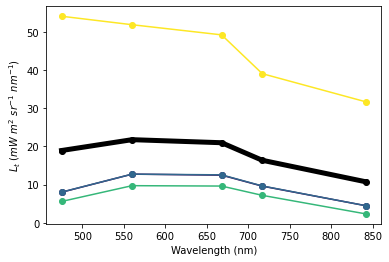

In [12]:
#plotting data from this function to make sure it looks good

lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')
print(lt_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

for i in range(len(lt_imgs)):
    plt.plot(wv, lt_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="") 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
plt.plot(wv, lt_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')


In [13]:
process_micasense_subset(project_dir=project_path, warp_img_dir=project_path+'/align_img', overwrite=True, sky=True)

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_sky_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
used warp dir ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
       [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
       [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
       [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
       [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:04.68214

'../../../10_01_20/0002SET/000_test/sky_lt_imgs'

(2, 5, 926, 1225)


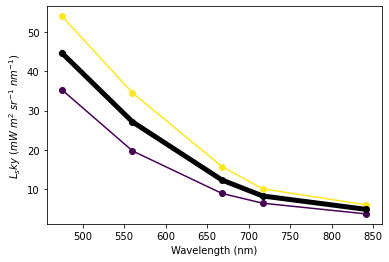

In [14]:
#plotting data from this function to make sure it looks good

lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs')
print(lsky_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    plt.plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$L_sky\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
plt.plot(wv, lsky_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')


### Load metadata from images
#### This function returns a list of metadata 


#AW notes- I'm wondering what the benefit of this function is if we have the write_exif_csv() function that saves the same metadata as a .csv?

In [15]:
df = load_img_fn_and_meta(img_dir=project_path+'/lt_imgs')
df.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,1280,960,-11.208938,-7.916905,-16.696712,2022-08-12 16:02:27
capture_2.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,1280,960,-20.642214,-8.073487,-17.074646,2022-08-12 16:02:29
capture_3.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,1280,960,-80.304408,-10.974186,-21.634724,2022-08-12 16:02:31
capture_4.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,1280,960,-79.640905,-11.099981,25.742701,2022-08-12 16:02:33


### Loading images
#### This function loads the numpy arrays of each .tif in an image directory

In [20]:
load_images(img_list = glob.glob(project_path+'/lt_imgs/*.tif'))


array([[[[0.00804333, 0.00793729, 0.00773955, ..., 0.00719604,
          0.00747167, 0.00748908],
         [0.00735689, 0.00753132, 0.00765531, ..., 0.00701523,
          0.00733989, 0.00748273],
         [0.0070529 , 0.00736668, 0.00762665, ..., 0.007519  ,
          0.00789201, 0.00806685],
         ...,
         [0.00548745, 0.00565179, 0.00592159, ..., 0.0056419 ,
          0.00576597, 0.00590172],
         [0.00541384, 0.00589847, 0.0058062 , ..., 0.00616943,
          0.00618882, 0.00583156],
         [0.00548837, 0.00547596, 0.00544705, ..., 0.0061988 ,
          0.006068  , 0.00617601]],

        [[0.01305651, 0.01384114, 0.0139703 , ..., 0.01173149,
          0.01156621, 0.01155434],
         [0.01283234, 0.01349893, 0.01370834, ..., 0.01144142,
          0.01162629, 0.01156501],
         [0.0129366 , 0.0130481 , 0.01351238, ..., 0.01119716,
          0.01085365, 0.01097419],
         ...,
         [0.01118851, 0.011319  , 0.01076224, ..., 0.01033175,
          0.01034655, 0.0

### Retrieving images and metadata
#### This function combines load_img_fn_and_meta() and load_images() function to return each image in an image directory as a numpy array and saves metadata as pandas dataframe. This function can be used to grab a subset of imagery from any stage of processing

In [19]:
imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')
img_metadata

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,id
filename,,,,,,,,,,,,,,,,
capture_1.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,1280,960,-11.208938,-7.916905,-16.696712,2022-08-12 16:02:27,1
capture_2.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,1280,960,-20.642214,-8.073487,-17.074646,2022-08-12 16:02:29,2
capture_3.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,1280,960,-80.304408,-10.974186,-21.634724,2022-08-12 16:02:31,3
capture_4.tif,../../../10_01_20/0002SET/000_test/lt_imgs/cap...,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,1280,960,-79.640905,-11.099981,25.742701,2022-08-12 16:02:33,4


In [14]:
retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')

(array([[[[0.00804333, 0.00793729, 0.00773955, ..., 0.00719604,
           0.00747167, 0.00748908],
          [0.00735689, 0.00753132, 0.00765531, ..., 0.00701523,
           0.00733989, 0.00748273],
          [0.0070529 , 0.00736668, 0.00762665, ..., 0.007519  ,
           0.00789201, 0.00806685],
          ...,
          [0.00548745, 0.00565179, 0.00592159, ..., 0.0056419 ,
           0.00576597, 0.00590172],
          [0.00541384, 0.00589847, 0.0058062 , ..., 0.00616943,
           0.00618882, 0.00583156],
          [0.00548837, 0.00547596, 0.00544705, ..., 0.0061988 ,
           0.006068  , 0.00617601]],
 
         [[0.01305651, 0.01384114, 0.0139703 , ..., 0.01173149,
           0.01156621, 0.01155434],
          [0.01283234, 0.01349893, 0.01370834, ..., 0.01144142,
           0.01162629, 0.01156501],
          [0.0129366 , 0.0130481 , 0.01351238, ..., 0.01119716,
           0.01085365, 0.01097419],
          ...,
          [0.01118851, 0.011319  , 0.01076224, ..., 0.01033175,
   

### Removing specular sun glint
#### This function grabs the first 30 images and calculates the overall mean and standard deviation of the NIR band. It runs through each image and masks pixels that are greater than the mean + std x glint factor. The lower the glint factor is, more pixels will be masked. 

In [26]:
std_glint_removal_method(lt_dir = project_path+'/lt_imgs', glint_corrected_lt_dir = project_path+'/lt_glint_corrected_imgs', glint_std_factor=.5)

#AW- not sure about grabbing the first 10 images.. these could be 10 without any glint so the mean and std would be a lot lower. I changed to 30? Should this be random, not the first 30?
#AW- we're currently removing different pixels from each band in an image since we're finding a different glint threshold for each of the 5 bands. 
#I changed this so we're only doing the glint filtering on the NIR band and applying that filtering to all bands. 


#manually made 'lt_glint_corrected_imgs' folder for this function to work 

The mean and std of Lt from first 30 images is:  0.010728069 0.031780522
Pixels will be masked where Lt(NIR) >  0.02661832980811596


True

'          \nfor im in glob.glob(glint_corrected_lt_dir + "/*.tif"):\n    with rasterio.open(im, \'r\') as Lt_src:\n        for i in range(4):\n            print(type(Lt_src.read(2)))\n            fig, ax = plt.subplots(2,2, figsize=(15,4))\n            img = ax[i].show(Lt_src.read(2), cmap=\'jet\', vmin=0.002, vmax=0.03)\n            #ax[i].pcolormesh(Lt_src.read(2))\n            fig.colorbar(img, ax=ax[i], fraction=0.046, pad=0.04)\n            #cbar = plt.colorbar()\n'

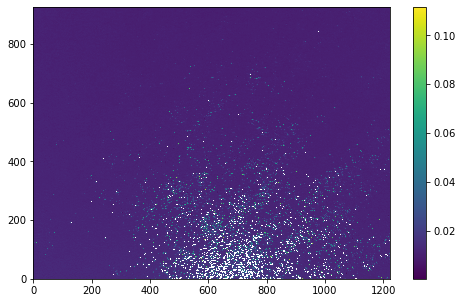

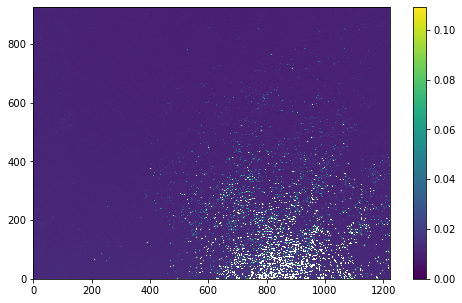

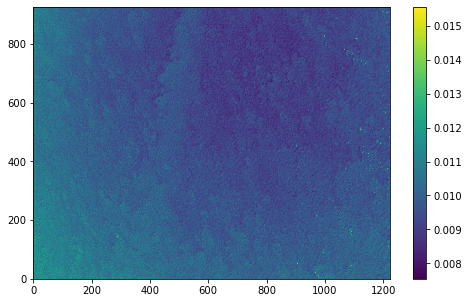

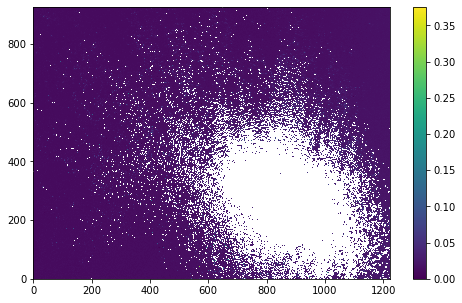

In [52]:
#plot individual tifs to see if glint is masked 

glint_corrected_lt_dir = project_path+'/lt_glint_corrected_imgs'

for im in glob.glob(glint_corrected_lt_dir + "/*.tif"):
    with rasterio.open(im, 'r') as Lt_src:
        profile = Lt_src.profile
        fig = plt.figure(figsize=(8,5))
        plt.pcolormesh(Lt_src.read(2))
        cbar = plt.colorbar()

#AW_notes- I'm trying to plot these as subplots but having trouble
'''          
for im in glob.glob(glint_corrected_lt_dir + "/*.tif"):
    with rasterio.open(im, 'r') as Lt_src:
        for i in range(4):
            print(type(Lt_src.read(2)))
            fig, ax = plt.subplots(2,2, figsize=(15,4))
            img = ax[i].show(Lt_src.read(2), cmap='jet', vmin=0.002, vmax=0.03)
            #ax[i].pcolormesh(Lt_src.read(2))
            fig.colorbar(img, ax=ax[i], fraction=0.046, pad=0.04)
            #cbar = plt.colorbar()
'''

### Calculating water leaving radiance (Lw)
#### The mobley_rho_method() is based off of the Mobley 1999 paper that uses this equation to calculate Lw = Lt - Lsky * rho 
#### The Mobley 1999 paper recommends that for a viewing direction of 40 deg from nadir and 135 deg from the Sun, a value of rho = 0.028 is acceptable only for wind speeds less than 5 m/s.
#### This function uses processed Lt images and Lsky images to calculate Lw (Lt - Lsky * rho) for each image. 

In [53]:
mobley_rho_method(sky_lt_dir = project_path+'/sky_lt_imgs', lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs', rho=0.028)

#manually made 'lw_imgs' folder for this function to work

True

#### The blackpixel_method() is based off the black pixel assumption which states the value of Lw in the NIR is negligable due to the strong absorptiong of water in the NIR. Therefore, any NIR signal can be assumed to be atmosphere and removed. 
#### This method is only valid in open ocean (Case 1) waters and should not be used in coastal waters where co-varying optical properties such as suspended sediment can provide a NIR signal. 

In [10]:
blackpixel_method(sky_lt_dir = project_path+'/sky_lt_imgs', lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs')

#manually made 'lw_imgs' folder for this function to work

True

#### The hedley_method() is based off the Hedley et al. (2005) paper that establishes linear relationships between NIR and visible bands based on a sample of the image pixels.

#### For each image set, a minimum NIR value (lowest 10%) is determined. The slope of a linear regression between this value and visible band values is determined.

#### Each pixel is corrected by this equation: Lw = Lt - b(Lt(NIR) - min(Lt(NIR))), where b is the slope of the linear regression. 

In [54]:
hedley_method(lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs')

#manually made 'lw_imgs' folder for this function to work

True

### Calculating remote sensing reflectance (Rrs) by dividing Lw by downwelling irradiance (Ed)
#### The panel_ed() method estimates Ed using images of the calibration reflectance panel provided by MicaSense. 
#### It divides these Ed measurements by Lw measurements created from one of the 3 Lw functions to calcualate and output images with units of Rrs. 
#### It also outputs a .csv of Ed measurements for each image

In [55]:
panel_ed(panel_dir = project_path+'/panel', lw_dir = project_path+'/lw_imgs', rrs_dir = project_path+'/rrs_imgs', output_csv_path=project_path)

#manually made 'rrs_imgs' directory for the function to work 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/panel


True

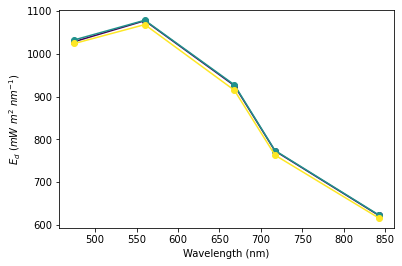

In [56]:
#Plotting data to make sure it looks good

ed = pd.read_csv(project_path+'/panel_ed.csv') 

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    plt.plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 


#### The dls_ed() method collects Ed measurements taken from the Downwelling Light Sensor (DLS) onboard the drone (if present). 
#### It divides these Ed measurements by Lw measurements created from one of the 3 Lw functions to calcualate and output images with units of Rrs. 
#### It also outputs a .csv of Ed measurements for each image

In [58]:
dls_ed(raw_water_dir=project_path+'/raw_water_imgs', lw_dir = project_path+'/lw_imgs', rrs_dir = project_path+'/rrs_imgs', output_csv_path=project_path)

#manually made 'rrs_imgs' directory for the function to work 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs


True

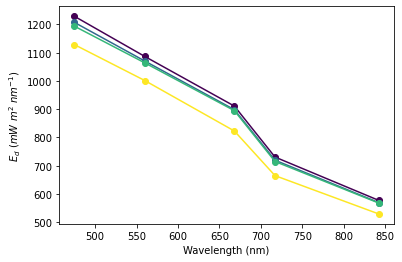

In [59]:
#Plotting data to make sure it looks good

ed = pd.read_csv(project_path+'/dls_ed.csv') 

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    plt.plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)')

In [62]:
#According to MicaSense, DLS does not perform well when light is constant due to movement of the drone- creates biased data along runs. 
#They recommend using panel during clear, sunny days and DLS + panel in overcast, completely cloudy conditions.

#So, I think a function combining the two would be good.. but I was having trouble doing that.

#https://support.micasense.com/hc/en-us/articles/360025336894-Using-Panels-and-or-DLS-in-Post-Processing)

In [63]:
#Do we need the rewrite_exif_data() function still? 

### Raw to Rrs processing
#### This function selects which glint correction method, Lw method, Ed method to use to calculate Rrs for all images 

In [60]:
process_raw_to_rrs(main_dir=project_path, ed_method='panel_ed', glint_correct=True, glint_std_factor=0.5, surface_reflection_correction='mobley_rho_method', output_csv_path=project_path)


Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
used warp dir ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
       [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
       [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
       [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
       [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:08.77975

/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9092090e-01,  7.3246547e-04, -8.6758029e-01],
       [ 6.0073420e-04,  9.8712063e-01, -4.7487357e-01],
       [ 1.5979347e-06,  1.3665929e-06,  1.0000000e+00]], dtype=float32), array([[ 9.9366832e-01,  8.2020154e-03, -3.2748260e+01],
       [ 4.2649364e-04,  9.9169523e-01,  3.5683990e-02],
       [ 4.4667590e-07, -7.3243618e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0103391e+00,  2.8778198e-03, -7.4464756e-01],
       [ 6.7657917e-03,  9.8913866e-01,  1.2885010e+01],
       [ 7.3613364e-06,  4.2012930e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0008420e+00,  1.9418603e-02, -4.1944111e+01],
       [ 7.0762925e-04,  9.9563247e-01, -3.0119851e-02],
       [ 7.9217926e-07, -3.6346937e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:03.29519

True

(4, 5, 926, 1225)
(2, 5, 946, 1230)


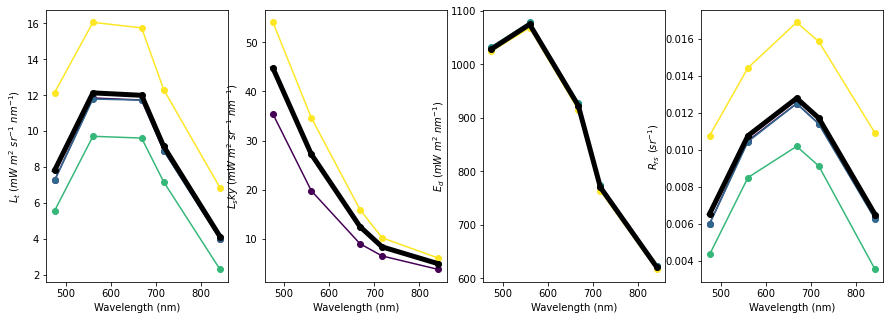

In [97]:
#Plotting data to make sure it looks good

fig, ax = plt.subplots(1,4, figsize=(15,5))

#lt
lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_glint_corrected_imgs')
print(lt_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

for i in range(len(lt_imgs)):
    ax[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[0].set_xlabel('Wavelength (nm)')
    ax[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
ax[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#lsky
lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs')
print(lsky_imgs.shape)
wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    ax[1].plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[1].set_xlabel('Wavelength (nm)')
    ax[1].set_ylabel('$L_sky\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
ax[1].plot(wv, lsky_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#ed
ed = pd.read_csv(project_path+'/panel_ed.csv')
#ed = pd.read_csv(project_path+'/dls_ed.csv')

colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    ax[2].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) #multiply by 1000 to convert to mW
    ax[2].set_xlabel('Wavelength (nm)')
    ax[2].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 

ax[2].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')

colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs)))

for i in range(len(rrs_imgs)):
    ax[3].plot(wv, np.nanmean(rrs_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[3].set_xlabel('Wavelength (nm)')
    ax[3].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
    
ax[3].plot(wv, np.nanmean(rrs_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

plt.show()


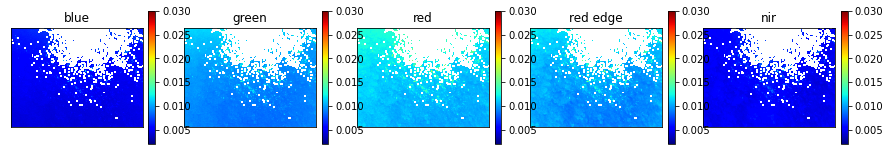

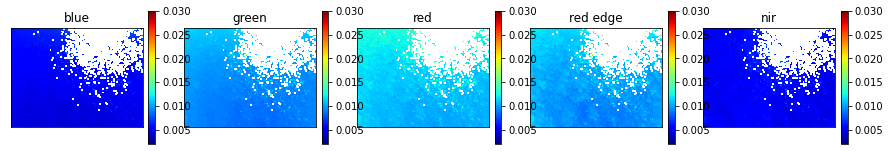

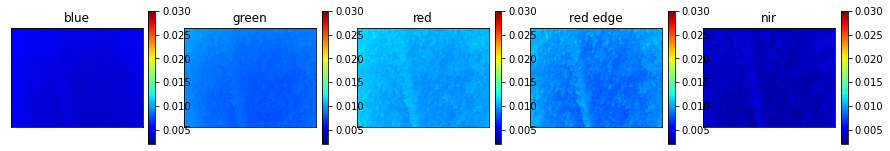

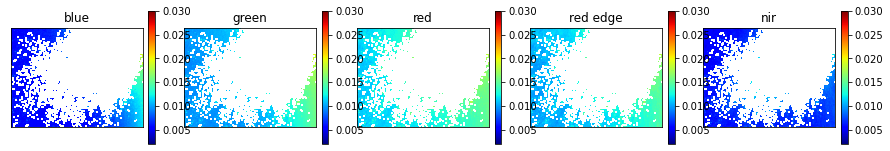

In [98]:
#plot individual tifs
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(4):
    fig, ax = plt.subplots(1,5, figsize=(15,4))

    for i in range(5):
        im = ax[i].imshow(rrs_imgs[j,i],cmap='jet', vmin=0.002, vmax=0.03)
        fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    plt.show()
    
#These seem to be in accurate Rrs value range

### Chlorophyll algorithms

### Open ocean (Case 1) Chl algs:
#### The chl_hu() function calculates chlorophyll using the Ocean Color Index algorithm developed by Hu et al. (2012)
#### The chl_ocx() function calculates chlorophyll using band ratio algorithm developed by O'Reilly et al. (__). Coefficients for L8 are being used.  
#### The chl_hu_ocx() function combines the two algorithms

#### More info on these algorithms can be found here: https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/


In [99]:
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')

rrs_imgs.shape

(4, 5, 926, 1225)

In [6]:
chl_hu = chl_hu(Rrsblue=rrs_imgs[:,0,:,:], Rrsgreen=rrs_imgs[:,1,:,:], Rrsred=rrs_imgs[:,2,:,:])
chl_ocx = chl_ocx(Rrsblue=rrs_imgs[:,0,:,:], Rrsgreen=rrs_imgs[:,1,:,:])
chl_hu_ocx = chl_hu_ocx(Rrsblue=rrs_imgs[:,0,:,:], Rrsgreen=rrs_imgs[:,1,:,:], Rrsred=rrs_imgs[:,2,:,:])

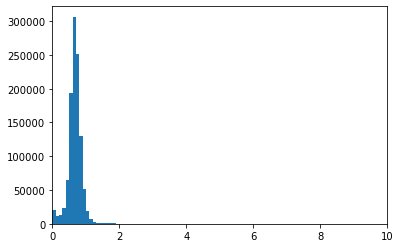

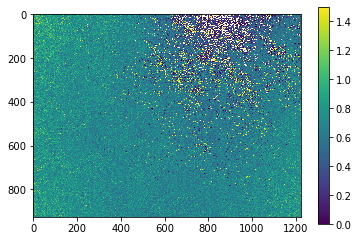

In [8]:
chl_hu[1,:,:][chl_hu[1,:,:] > 50] = 50
plt.hist(chl_hu[1,:,:].flatten(),bins=500)
plt.xlim(0,10)
plt.show()

plt.imshow(chl_hu[1,:,:], vmin=0, vmax=1.5, interpolation='none')
cbar = plt.colorbar()

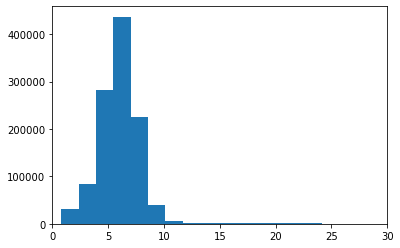

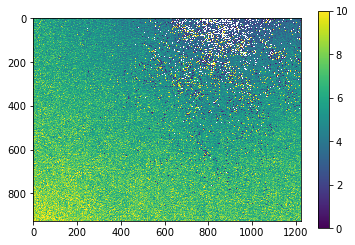

In [10]:
plt.hist(chl_ocx[1,:,:].flatten(),bins=1000)
plt.xlim(0,30)
plt.show()

plt.imshow(chl_ocx[1,:,:], vmin=0, vmax=10, interpolation='none')
cbar = plt.colorbar()

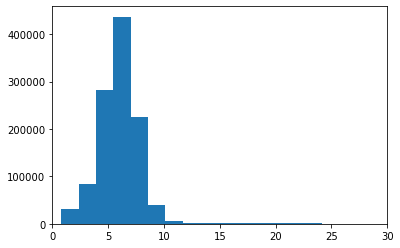

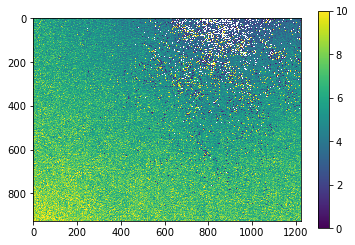

In [11]:
plt.hist(chl_hu_ocx[1,:,:].flatten(),bins=1000)
plt.xlim(0,30)
plt.show()

plt.imshow(chl_hu_ocx[1,:,:], vmin=0, vmax=10, interpolation='none')
cbar = plt.colorbar()

#AW_notes- I'm not sure if this switching alg is working.. it looks to be the same as the oc2 output above? 

### Coastal and Inland (Case 2) Chlorophyll Algorithms
#### 

In [7]:
chl_gitelson = chl_gitelson(Rrsred= rrs_imgs[:,2,:,:], Rrsrededge= rrs_imgs[:,3,:,:])

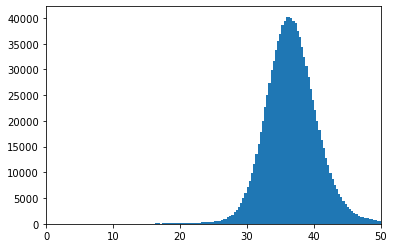

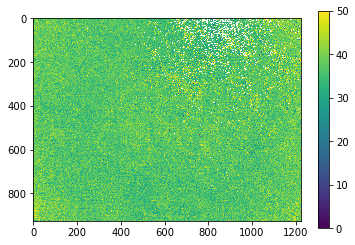

In [14]:
plt.hist(chl_gitelson[1,:,:].flatten(),bins=1000)
plt.xlim(0,50)
plt.show()

plt.imshow(chl_gitelson[1,:,:], vmin=0, vmax=50, interpolation='none')
cbar = plt.colorbar()


### Total suspended matter (TSM) retrival algorithm

In [6]:
nechad_tsm = nechad_tsm(Rrsred = rrs_imgs[:,2,:,:])

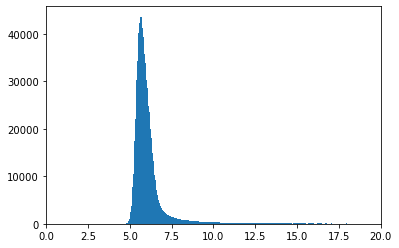

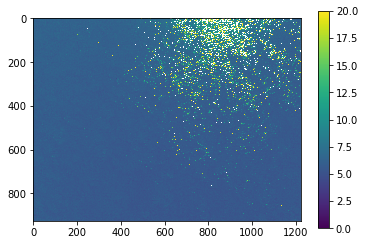

In [7]:
plt.hist(nechad_tsm[1,:,:].flatten(),bins=1000)
plt.xlim(0,20)
plt.show()

plt.imshow(nechad_tsm[1,:,:], vmin=0, vmax=20, interpolation='none')
cbar = plt.colorbar()

In [11]:
chl_list = []
#Taking mean chl of every image and converting to point
for i in range(len(rrs_imgs)):
    chl = chl_hu(Rrsblue=rrs_imgs[i,0,:,:], Rrsgreen=rrs_imgs[i,1,:,:], Rrsred=rrs_imgs[i,2,:,:])
    chl_point = np.nanmean(~np.isnan(chl), axis=(0,1))
    chl_list.append(chl_point)

chl_list

[0.9850081544496848, 0.9840419623572971, 1.0, 0.7727191783840966]

In [13]:
rrs_img_metadata['Chl'] = chl_list
rrs_img_metadata

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,id,Chl
filename,,,,,,,,,,,,,,,,,
capture_1.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,1280,960,-11.208938,-7.916905,-16.696712,2022-08-12 16:02:27,1,0.985008
capture_2.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,1280,960,-20.642214,-8.073487,-17.074646,2022-08-12 16:02:29,2,0.984042
capture_3.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,1280,960,-80.304408,-10.974186,-21.634724,2022-08-12 16:02:31,3,1.000000
capture_4.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,1280,960,-79.640905,-11.099981,25.742701,2022-08-12 16:02:33,4,0.772719


<AxesSubplot:>

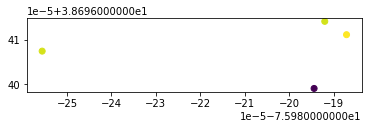

In [32]:
chl_gdf = gpd.GeoDataFrame(rrs_img_metadata, geometry=gpd.points_from_xy(rrs_img_metadata['    GPSLongitude'], rrs_img_metadata['    GPSLatitude']))


chl_gdf.plot('Chl')


Text(0, 0.5, 'Latitude')

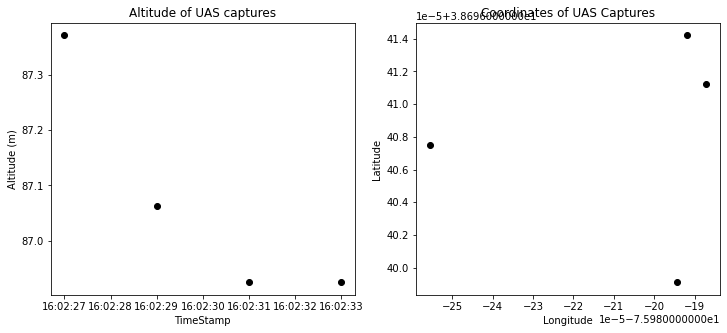

In [37]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#plot altitude
ax[0].scatter(rrs_img_metadata['UTC-Time'].values, rrs_img_metadata['    GPSAltitude'].values, color='black')
# ax[0].set_xticks(rotation=60)
ax[0].set_title("Altitude of UAS captures")
ax[0].set_xlabel("TimeStamp")
ax[0].set_ylabel("Altitude (m)")

#plot lat, lon
ax[1].scatter(rrs_img_metadata['    GPSLongitude'].values, rrs_img_metadata['    GPSLatitude'].values, color='black')
ax[1].set_title("Coordinates of UAS Captures")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")



### Georeferencing 


In [5]:
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')
rrs_img_metadata

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,id
filename,,,,,,,,,,,,,,,,
capture_1.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,1280,960,-11.208938,-7.916905,-16.696712,2022-09-07 16:02:27,1
capture_2.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,1280,960,-20.642214,-8.073487,-17.074646,2022-09-07 16:02:29,2
capture_3.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,1280,960,-80.304408,-10.974186,-21.634724,2022-09-07 16:02:31,3
capture_4.tif,../../../10_01_20/0002SET/000_test/rrs_imgs/ca...,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,1280,960,-79.640905,-11.099981,25.742701,2022-09-07 16:02:33,4


In [6]:
rrs_imgs.shape

(4, 5, 926, 1225)

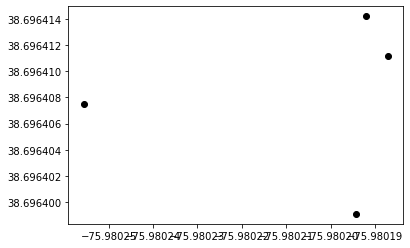

In [7]:
plt.scatter(rrs_img_metadata['    GPSLongitude'].values, rrs_img_metadata['    GPSLatitude'].values, color='black')
plt.ticklabel_format(useOffset=False)  
plt.show()

In [6]:
# space location / scaling factor - half the image

def spacetotopdown(top_im, cam, image_size, scaling):
    x1 = top_im.shape[0]/2 + cam.spaceFromImage([0,0])[0] / scaling
    y1 = top_im.shape[1]/2 - cam.spaceFromImage([0,0])[1] / scaling
    
    x2 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,0])[0] / scaling
    y2 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,0])[1] / scaling
    
    x3 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[0] / scaling
    y3 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[1] / scaling
    
    x4 = top_im.shape[0]/2 + cam.spaceFromImage([0,image_size[1]-1])[0] / scaling
    y4 = top_im.shape[1]/2 - cam.spaceFromImage([0,image_size[1]-1])[1] / scaling
    return(np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]]))
    #return([x1,x2,x3,x4],[y1, y2, y3,y4])

In [7]:
f = rrs_img_metadata.iloc[0]['    FocalLength']
print(f)
image_size = [rrs_img_metadata.iloc[0]['    ImageWidth'], rrs_img_metadata.iloc[0]['ImageHeight']]
print(image_size)
pitch = rrs_img_metadata.iloc[0]['GPSPitch']
roll = rrs_img_metadata.iloc[0]['GPSRoll']
yaw = rrs_img_metadata.iloc[0]['    GPSImgDirection']
alt = rrs_img_metadata.iloc[0]['    GPSAltitude']
lat = rrs_img_metadata.iloc[0]['    GPSLatitude']
lon = rrs_img_metadata.iloc[0]['    GPSLongitude']

5.434319812499999
[1280, 960]


In [16]:
import cameratransform as ct

cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         image=image_size),
               ct.SpatialOrientation(elevation_m=alt, # img.altitude,
                                     tilt_deg=pitch,
                                     roll_deg=roll,
                                    heading_deg=yaw,
                                    pos_x_m=0, pos_y_m=0))

# gps pts are lat lon
cam.setGPSpos(lat, lon, alt)

In [34]:
rrs_imgs.shape

(4, 5, 926, 1225)

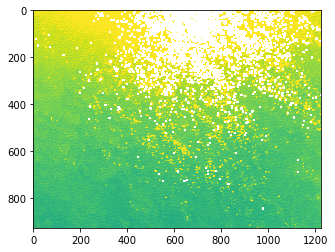

In [135]:
plt.imshow(rrs_imgs[0,0,:,:], vmin=0, vmax=.0065)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[495.49508269 548.92998944]
 [648.91756646 563.26270363]
 [640.61702021 682.43327798]
 [481.8113312  665.87681168]]


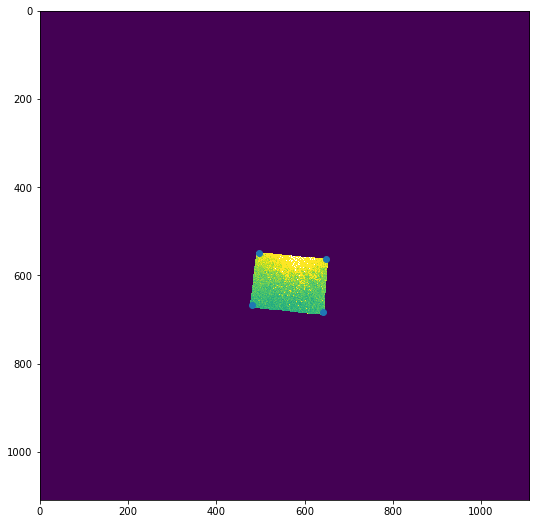

In [137]:
fig,ax = plt.subplots(figsize=(9,9))
scaling = .2
              
# this 120 value is approximate and based on altitude, FOV, and viewing geometry
top_im = cam.getTopViewOfImage(rrs_imgs[0,0,:,:], [-100, 100,-100, 100], skip_size_check=True)
print(top_im)

# Now get the image coordinates of the corners of the original image but in the top down image
image_coords = spacetotopdown(top_im, cam, image_size, scaling)
print(image_coords)

# show this image
ax.imshow(top_im, interpolation='none', vmin=0, vmax=0.0065)
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");
ax.scatter(image_coords[:,0],image_coords[:,1])

In [138]:
# these are the coordinates of the image corners
coords = np.array([
    cam.gpsFromImage([0               , 0]), \
    cam.gpsFromImage([image_size[0]-1 , 0]), \
    cam.gpsFromImage([image_size[0]-1 , image_size[1]-1]), \
    cam.gpsFromImage([0               , image_size[1]-1])])

gcp1 = rasterio.control.GroundControlPoint(row=image_coords[0,0], col=image_coords[0,1], x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_coords[1,0], col=image_coords[1,1], x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_coords[2,0], col=image_coords[2,1], x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=image_coords[3,0], col=image_coords[3,1], x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)
[gcp1, gcp2, gcp3, gcp4]

[GroundControlPoint(row=495.49508268699407, col=548.9299894428489, x=-75.98039157884172, y=38.69641751824556, z=0.0, id='9f9c9172-5b30-47b4-8d55-a391f939983d'),
 GroundControlPoint(row=648.9175664614796, col=563.2627036292739, x=-75.98003801158058, y=38.696391739037146, z=0.0, id='7aa7ff3b-63b4-4748-b03c-17de0c57cdb7'),
 GroundControlPoint(row=640.6170202055689, col=682.4332779784959, x=-75.98005714105997, y=38.69617739666589, z=0.0, id='96b1bb88-0779-45f7-a705-54ee4033f690'),
 GroundControlPoint(row=481.8113311950517, col=665.8768116792209, x=-75.9804231130205, y=38.69620717548146, z=0.0, id='b759689a-eedc-45a8-8226-866eb91b76c8')]

In [139]:
with rasterio.Env():
    
    # open the original image to get some of the basic metadata
    with rasterio.open(os.path.join(project_path, 'rrs_imgs', 'capture_1.tif'), 'r') as src:
        profile = src.profile
        print('initial profile')
        print(profile)
               
        src_crs = "EPSG:4326"  # This is the crs of the GCPs
        dst_crs = "EPSG:4326"

        tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        profile.update(
            dtype=rasterio.float32,
            transform = tsfm,
            crs=dst_crs,
            width=top_im.shape[0], # TODO unsure if this is correct order
            height=top_im.shape[1]
        )
        
        print('updated profile')
        print(profile)
 
        #new_fn = path_name.split('/')[-1].split('.')[0]+'_georeferenced.tif'
        #print(new_fn)
        with rasterio.open(os.path.join(project_path, 'georeferenced_imgs', 'capture_1.tif'), 'w', **profile) as dst:
            # we then need to transpose it because it gets flipped compared to expected output
            dst.write(top_im.T.astype(rasterio.float32), 1)


initial profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1225, 'height': 926, 'count': 5, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1109, 'height': 1109, 'count': 5, 'crs': 'EPSG:4326', 'transform': Affine(-8.022582622008677e-13, 2.3045301174255972e-06, -75.9815334614715,
       -1.7986186224807785e-06, -5.359969283476572e-13, 38.69740483419269), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1109, 'height': 1109, 'count': 5, 'crs': CRS.from_epsg(4326), 'transform': Affine(-8.022582622008677e-13, 2.3045301174255972e-06, -75.9815334614715,
       -1.7986186224807785e-06, -5.359969283476572e-13, 38.69740483419269)}


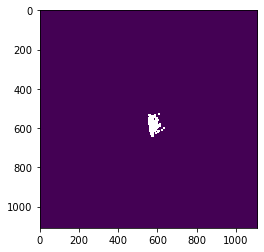

In [140]:
with rasterio.open(os.path.join(project_path, 'georeferenced_imgs', 'capture_1.tif')) as source:
    print(source.read(1))
    plt.imshow(source.read(1), vmin=0, vmax=65000)
    print(source.meta)

#### Putting it altogether 

In [66]:
rrs_imgs[i,0,:,:].T.shape

(1225, 926)

In [64]:
image_size

[1280, 960]

(500, 500)
initial profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1225, 'height': 926, 'count': 5, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 500, 'height': 500, 'count': 5, 'crs': 'EPSG:4326', 'transform': Affine(4.157728343649496e-09, 2.4107023407648276e-06, -75.98085314184627,
       -1.8680570183731152e-06, -1.752407777442916e-09, 38.696874505107175), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
(500, 500)
initial profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1225, 'height': 926, 'count': 5, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 500, 'height': 500, 'count': 5, 'crs': 'EPSG:43

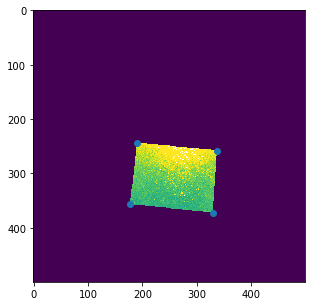

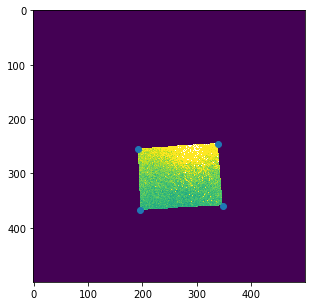

In [26]:
import cameratransform as ct

for i in range(len(rrs_img_metadata[0:2])):
    f = rrs_img_metadata.iloc[i]['    FocalLength']
    image_size = [rrs_img_metadata.iloc[i]['    ImageWidth'], rrs_img_metadata.iloc[i]['ImageHeight']]
    pitch = rrs_img_metadata.iloc[i]['GPSPitch']
    roll = rrs_img_metadata.iloc[i]['GPSRoll']
    yaw = rrs_img_metadata.iloc[i]['    GPSImgDirection']
    alt = rrs_img_metadata.iloc[i]['    GPSAltitude']
    lat = rrs_img_metadata.iloc[i]['    GPSLatitude']
    lon = rrs_img_metadata.iloc[i]['    GPSLongitude']
    
    cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         image=image_size),
               ct.SpatialOrientation(elevation_m=alt, # img.altitude,
                                     tilt_deg=pitch,
                                     roll_deg=roll,
                                    heading_deg=yaw,
                                    pos_x_m=0, pos_y_m=0))

    # gps pts are lat lon
    cam.setGPSpos(lat, lon, alt)
    
    fig,ax = plt.subplots(figsize=(5,5))
    scaling = .2

    # this 120 value is approximate and based on altitude, FOV, and viewing geometry
    top_im = cam.getTopViewOfImage(rrs_imgs[i,0,:,:], [-50, 50,-50, 50], skip_size_check=True, scaling=scaling)
    print(top_im.shape)

    # Now get the image coordinates of the corners of the original image but in the top down image
    image_coords = spacetotopdown(top_im, cam, rrs_imgs[i,0,:,:].T.shape, scaling)
    #print(image_coords)

    # show this image
    ax.imshow(top_im, interpolation='none', vmin=0, vmax=0.0065)
    # ax.set_xlabel("x position in m")
    # ax.set_ylabel("y position in m");
    ax.scatter(image_coords[:,0],image_coords[:,1])
    
    # these are the coordinates of the image corners
    coords = np.array([
        cam.gpsFromImage([0               , 0]), \
        cam.gpsFromImage([image_size[0]-1 , 0]), \
        cam.gpsFromImage([image_size[0]-1 , image_size[1]-1]), \
        cam.gpsFromImage([0               , image_size[1]-1])])

    gcp1 = rasterio.control.GroundControlPoint(row=image_coords[0,0], col=image_coords[0,1], x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
    gcp2 = rasterio.control.GroundControlPoint(row=image_coords[1,0], col=image_coords[1,1], x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
    gcp3 = rasterio.control.GroundControlPoint(row=image_coords[2,0], col=image_coords[2,1], x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
    gcp4 = rasterio.control.GroundControlPoint(row=image_coords[3,0], col=image_coords[3,1], x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)
    
    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rasterio.Env():
        # open the original image to get some of the basic metadata
        with rasterio.open(os.path.join(project_path, 'rrs_imgs', 'capture_' + str(i+1) + '.tif'), 'r') as src:
            profile = src.profile
            print('initial profile')
            print(profile)

            src_crs = "EPSG:4326"  # This is the crs of the GCPs
            dst_crs = "EPSG:4326"

            tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
            profile.update(
                dtype=rasterio.float32,
                transform = tsfm,
                crs=dst_crs,
                width=top_im.shape[0], # TODO unsure if this is correct order
                height=top_im.shape[1]
            )

            print('updated profile')
            print(profile)

            #new_fn = path_name.split('/')[-1].split('.')[0]+'_georeferenced.tif'
            #print(new_fn)
            with rasterio.open(os.path.join(project_path, 'georeferenced_imgs', 'capture_' + str(i+1) + '.tif'), 'w', **profile) as dst:
                # we then need to transpose it because it gets flipped compared to expected output
                dst.write(top_im.T.astype(rasterio.float32), 1)


BoundingBox(left=-75.98085314184627, bottom=38.6959396003941, right=-75.97964571181171, top=38.696874505107175)
BoundingBox(left=-75.98078910410335, bottom=38.69594755388912, right=-75.97958273468964, top=38.696881612521885)
-75.98085314184627 38.6959396003941 -75.97958273468964 38.696881612521885


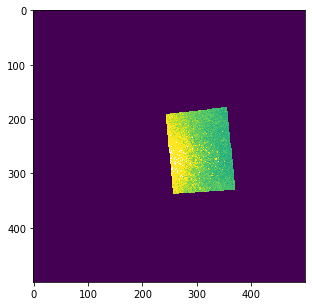

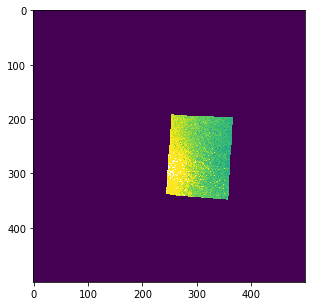

In [27]:
dirpath = os.path.join(project_path, 'georeferenced_imgs')
search_criteria = "*.tif"
q = os.path.join(dirpath, search_criteria)

tif_files = glob.glob(q)

src_files_to_mosaic = []
src_bounds_left = []
src_bounds_bottom = []
src_bounds_right = []
src_bounds_top = []


for i in tif_files:
    src = rasterio.open(i)
    
    print(src.bounds)
    src_bounds_left.append(src.bounds[0])
    src_bounds_bottom.append(src.bounds[1])
    src_bounds_right.append(src.bounds[2])
    src_bounds_top.append(src.bounds[3])
    
    fig,ax = plt.subplots(figsize=(5,5))
    ax.imshow(src.read(1), interpolation='none', vmin=0, vmax=0.0065)
    
    src_files_to_mosaic.append(src)
    
bounds_left = min(src_bounds_left)
bounds_bottom = min(src_bounds_bottom)
bounds_right = max(src_bounds_right)
bounds_top = max(src_bounds_top)

print(bounds_left, bounds_bottom, bounds_right, bounds_top)


In [23]:
src_files_to_mosaic

[<open DatasetReader name='../../../10_01_20/0002SET/000_test/georeferenced_imgs/capture_1.tif' mode='r'>,
 <open DatasetReader name='../../../10_01_20/0002SET/000_test/georeferenced_imgs/capture_2.tif' mode='r'>]

In [28]:

from rasterio.merge import merge
from rasterio.plot import show

print(bounds_left, bounds_bottom, bounds_right, bounds_top)

mosaic, out_trans = merge(src_files_to_mosaic, bounds=[-75.98, 38.68, -75.96, 38.71]) # [bounds_left, bounds_bottom, bounds_right, bounds_top]
print(mosaic.shape)
print(out_trans)

mosaic_blue = mosaic[2,:,:] #.astype('float')
mosaic_blue[mosaic_blue == 0] = 'nan'
show(mosaic_blue)

-75.98085314184627 38.6959396003941 -75.97958273468964 38.696881612521885


WindowError: Bounds and transform are inconsistent